In [1]:
import os
os.environ['FFMPEG_BINARY'] = 'ffmpeg'

import io
import PIL.Image, PIL.ImageDraw

import requests

import numpy as np
import matplotlib.pyplot as plt
import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

# Notebook dependencies
from IPython.display import clear_output

from torch.profiler import profile, record_function, ProfilerActivity

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device is {}'.format(device))

device is cuda


In [3]:
# Utility functions

TARGET_SIZE = 40

def load_image(url, max_size=TARGET_SIZE):
  r = requests.get(url)
  img = PIL.Image.open(io.BytesIO(r.content))
  img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)
  img = np.float32(img) / 255.0

  # premultiply RGB by Alpha
  img[..., :3] *= img[..., 3:]
  return img

def load_emoji(emoji):
  code = hex(ord(emoji))[2:].lower()
  url = 'https://github.com/googlefonts/noto-emoji/blob/main/png/128/emoji_u%s.png?raw=true'%code
  return load_image(url)

def to_rgba(x):
  "This function used outside model, using original shaping conventions"
  return x[..., :4]

def get_living_mask(x):
  "This function used within model with PyTorch shaping conventions"
  alpha = x[:, 3:4, :, :]
  return F.max_pool2d(alpha, kernel_size=3, stride=1, padding=1) > 0.1

def plot_loss(loss_log):
  plt.figure(figsize=(10, 4))
  plt.title('Loss history (log10)')
  plt.plot(np.log10(loss_log), '.', alpha=0.1)
  plt.show()


In [4]:
# Parameters

CHANNEL_N = 16
TARGET_PADDING = 16
BATCH_SIZE = 8
CELL_FIRE_RATE = 0.5

TARGET_EMOJI = "🛩"

# Load target image
target_img = load_emoji(TARGET_EMOJI)

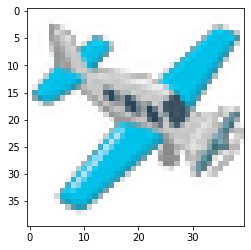

In [5]:
plt.imshow(target_img)
plt.show()

In [29]:
# Define Model

class CAModel(nn.Module):
  def __init__(self, channel_n=CHANNEL_N, fire_rate=CELL_FIRE_RATE):
    super().__init__()
    self.channel_n = channel_n
    self.fire_rate = fire_rate

    self.dmodel = nn.Sequential(
        nn.Conv2d(in_channels=self.channel_n*3, out_channels=128, kernel_size=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=128, out_channels=self.channel_n, kernel_size=1)
    ).to(device)

  def perceive(self, x, angle=0.0):
    """Pytorch does convolutions differently. Reshape accordingly
      input is (batch, in_channels, H, W)
      kernel is (filter_height, filter_width, in_channels, channel_multiplier)
      but should be (out_channels, in_channels / groups, H, W)"""
    identify = torch.as_tensor([0, 1, 0], dtype=torch.float32)
    identify = torch.outer(identify, identify)
    dx = torch.as_tensor(np.outer([1, 2, 1], [-1, 0, 1]) / 8.0, dtype=torch.float32) # Sobel filter
    dy = dx.T
    c, s = torch.cos(torch.tensor(angle)), torch.sin(torch.tensor(angle))
    kernel = torch.stack((identify, c*dx-s*dy, s*dx+c*dy)).to(device)
    kernel = torch.repeat_interleave(kernel, self.channel_n, dim=0).view(self.channel_n*3, 1, 3, 3)
    return F.conv2d(x, kernel, padding='same', groups=self.channel_n)

  def forward(self, x, fire_rate=None, angle=0.0, step_size=1.0):
    x = torch.permute(x, (0, 3, 1, 2))
    # x = x.view(0, 3, 1, 2)
    pre_life_mask = get_living_mask(x)

    y = self.perceive(x, angle) # y should be on device
    dx = self.dmodel(y)*step_size
    if fire_rate is None:
      fire_rate = self.fire_rate
    update_mask = torch.rand(x.shape, dtype=torch.float32)[:, :, :, :1] <= fire_rate
    x += dx * update_mask.to(device)

    post_life_mask = get_living_mask(x)
    life_mask = pre_life_mask & post_life_mask
    result = x * life_mask
    return torch.permute(result, (0, 2, 3, 1)) # send it back [batch_size, H, W, in_channels]

CAModel().dmodel

Sequential(
  (0): Conv2d(48, 128, kernel_size=(1, 1), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
)

seed shape is torch.Size([72, 72, 16])


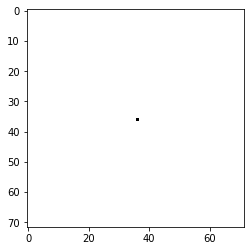

In [30]:
# Make training sample

p = TARGET_PADDING
target_img_tensor = torch.tensor(target_img)
pad_target = torch.nn.functional.pad(target_img_tensor, (0, 0, p, p, p, p))
h, w = pad_target.shape[:2]
seed = torch.zeros(h, w, CHANNEL_N, dtype=torch.float32)
seed[h//2, w//2, 3:] = 1.0
print(f'seed shape is {seed.shape}')

plt.imshow(seed[..., :4])
plt.show()

In [34]:
# Training Sequence

class Train:
  def __init__(self, ca_model, target, lr=2e-3):
    self.ca = ca_model
    self.target = target
    self.lr = lr
    # Initialize optimizer = no learning rate scheduler for now
    self.optim = torch.optim.Adam(self.ca.parameters(), lr=self.lr)
    # Use library MSELoss
    self.loss_f = nn.MSELoss()

    # Log the training progress
    self.loss_log = []

  def train(self, n_steps=1000):
    "Just support Growing mode for now"

    for i in range(n_steps+1):
      # Seed input each time (starting from a single seed pixel)
      x0 = torch.repeat_interleave(seed[None, ...], BATCH_SIZE, dim=0).to(device)

      # Run through a single training step of the model
      loss = self._train_step(x0)
      self.loss_log.append(loss)
      print(f'loss log is {self.loss_log}')

      # Printing
      if i % 100 == 0:
        # clear_output()

        # visualize batch
        # plot loss
        plot_loss(self.loss_log)
        # export model

      print('\r step: %d, log10(loss): %.3f'%(len(self.loss_log), np.log10(loss)), end='')

  def _train_step(self, x):
    """Perform the update step some random number of times"""
    iter_n = np.random.randint(64, 97, dtype=np.int32)
    # Clear previous gradients accumulated on parameters
    self.optim.zero_grad()
    # x = x.to(device)
    for _ in range(iter_n):
      # Forward pass of model
      x = self.ca(x)
    # Compute loss

    loss = self.loss_f(to_rgba(x), self.target)
    # loss = self._loss_f(x, self.target.to(device))
    del x
    # Compute gradients
    loss.backward
    # Update parameters
    self.optim.step()

    detached_loss = loss.detach().cpu().numpy()
    del loss
    torch.cuda.empty_cache()

    return detached_loss

  def _loss_f(self, output, target):
    return torch.square(to_rgba(output) - target).mean(dim=(-2, -3, -1))


In [47]:
torch.cuda.empty_cache()
!nvidia-smi

Fri Mar 10 21:54:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    28W /  70W |  15067MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

loss log is [array(0.0613986, dtype=float32)]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([72, 72, 4])) that is different to the input size (torch.Size([8, 72, 72, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


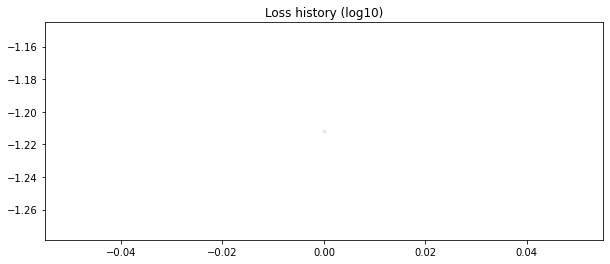

 step: 1, log10(loss): -1.212loss log is [array(0.0613986, dtype=float32), array(0.0712155, dtype=float32)]
 step: 2, log10(loss): -1.147loss log is [array(0.0613986, dtype=float32), array(0.0712155, dtype=float32), array(0.09376743, dtype=float32)]
 step: 3, log10(loss): -1.028loss log is [array(0.0613986, dtype=float32), array(0.0712155, dtype=float32), array(0.09376743, dtype=float32), array(0.07103686, dtype=float32)]
 step: 4, log10(loss): -1.149

OutOfMemoryError: ignored

In [36]:
# Initalize and initiate training sequence
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
  with record_function("model_inference"):
    train = Train(CAModel().to(device), pad_target.to(device))
    train.train()

In [10]:
# print(prof.key_averages().table(sort_by="cuda_memory_usage", row_limit=15))
print(prof.key_averages(group_by_input_shape=True).table(sort_by="cuda_memory_usage", row_limit=10, max_src_column_width=None, header="CUDA memory usage"))

CUDA memory usage
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  --------------------------------------------------------------------------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls                                                                      Input Shapes  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  --------------------------------------------------------------------------------  
                                            aten::zeros         0.04%       4.245ms         0.04%       4.303ms     358.583us       0.000us  

In [ ]:
x0 = np.repeat(seed[None, ...], BATCH_SIZE, 0)
print(seed.shape)
print(x0.shape)

torch.Size([72, 72, 16])
torch.Size([8, 72, 72, 16])


In [ ]:
x0_tensor = torch.repeat_interleave(seed[None, ...], BATCH_SIZE, dim=0)
x0_tensor.shape

torch.Size([8, 72, 72, 16])

In [ ]:
ca = CAModel()
output = ca(x0)
output.shape

torch.Size([8, 16, 72, 72])

In [33]:
import tensorflow as tf

In [34]:
def loss_f(x):
  return tf.reduce_mean(tf.square(to_rgba(x)-pad_target), [-2, -3, -1])

In [ ]:
seed

In [38]:
testing = loss_f(seed)
print(type(testing))
print(testing.shape)
print(testing)

<class 'tensorflow.python.framework.ops.EagerTensor'>
()
tf.Tensor(0.061350375, shape=(), dtype=float32)
